In [1]:

class Project:
    def __init__(self, project_id, max_matches, min_grade):
        self.project_id = project_id
        self.max_matches = max_matches
        self.min_grade = min_grade
        self.matches = []

class Student:
    def __init__(self, student_id, preference_list, grade):
        self.student_id = student_id
        self.preference_list = preference_list
        self.grade = grade
        self.matches = []

class Edges:
    def __init__(self, student_id, project_id):
        self.student_id = student_id
        self.project_id = project_id

# Initialize empty lists for projects and students
projects = []
students = []
edges = []
# Read input from file
with open('input.txt', 'r') as f:
    lines = f.readlines()

# Process each line in the input file
for line in lines:
    line = line.strip()
    
    # Process project information (format: (Pxx, max_matches, max_grade))
    if line.startswith("(P"):
        parts = line.split(',')
        project_id = parts[0].strip('() ')
        min_grade = int(parts[1].strip())
        max_grade = int(parts[2].strip(') '))
        projects.append(Project(project_id, min_grade, max_grade))
    
    # Process student information (format: (Ax):(P1, P2, P3) (grade))
    if line.startswith("(A"):
        student_info = line.split(':')
        student_id = student_info[0].strip('() ')
        projects_list = student_info[1].split(')')[0].strip('() ').split(',')
        preferred_projects = [p.strip() for p in projects_list]
        grade = int(student_info[1].split(')')[1].strip('() '))
        students.append(Student(student_id, preferred_projects, grade))

In [2]:
def students_finished_proposing(students):
    for student in students:
        if student and student.preference_list:
            return False
    print("There are no more proposals to be done.")
    return True

In [3]:
def find_student_by_id(student_id, students):
    for student in students:
        if student.student_id == student_id:
            return student
    return None

def find_project_by_id(project_id, projects):
    for project in projects:
        if project.project_id == project_id:
            return project
    return None

In [4]:
# used when a project unmatches a student to accept a more preferred student
def break_match(project, student, edges, free_students, deferred_students):
    try:
        student.matches.clear()
        project.matches.remove(student)
        edges.remove((student, project))

        free_students.append(student)
        deferred_students.append(student)
    except Exception as e:
        print("Error: Attempted to break a match that doesn't exist?")
        print(f"Student: {student.student_id}, Project: {project.project_id}")

# as projects prefer students with higer grades, worst match is worst grade student
def find_worst_student(project):
    try:
        project.matches.sort(key=lambda x: x.grade, reverse=True) # sort matched by grade, ascending
        worst = project.matches[-1]
        # print every grade of students in project
        print(f"        Students in project: {[f'{student.student_id}, Grade: {student.grade}' for student in project.matches]}")

    except Exception as e:
        print("Error: No students found in project? only call this function if project has more matches than maximum") # list is empty-- was project maxed out before calling this function?
        print(f"Project: {project.project_id}, Matches: {len(project.matches)}")
    return worst

        

In [5]:
# to show that the deferred student between equally preferable students is the last one to propose
# as the worst student is the deferred one
p = Project("P1", 2, 1)
p.matches.append(Student("A2", ["P1", "P2", "P3"], 1))
p.matches.append(Student("A1", ["P1", "P2", "P3"], 1))
print(find_worst_student(p).student_id)

        Students in project: ['A2, Grade: 1', 'A1, Grade: 1']
A1


In [6]:
def extract_number(student_id):
    return int(student_id[1:])

# reset students, retry
def reset_students_preferences(edges, original_students):
    students = [edge[0] for edge in edges]
    for student in students:
        s = find_student_by_id(student.student_id, original_students)
        student.preference_list = s.preference_list.copy()
    

# a project has preference 0 for a student with the highest grade
def rank_student(student):
    preferable_scores = [5,4,3]
    return preferable_scores.index(student.grade)

# a student has preference 0 for their most preferred project
def rank_project(student, project):
    rank = student.preference_list.index(project.project_id)
    return rank


In [7]:
# following  Student-oriented algorithm for SPA by David J. Abraham a 1, Robert W. Irving b, David F. Manlove on "Two algorithms for the Student-Project Allocation problem"
# https://www.sciencedirect.com/science/article/pii/S1570866706000207#sec006, image of presented pseudocode in repository 'Student-oriented algorithm for SPA by Abraham, Irving, Manlove .png'
# an implementation of Gale Shapley stable matching

from copy import deepcopy 
# all students are unmatched
# all projects are unmatched
def gale_shapley(students, projects, edges):

    free_students = deepcopy(students) # to preserve students preference list for edge weight, which will be popped

    while len(free_students) > 0 and not students_finished_proposing(free_students): 

        deferred_students = [] # formerly matched that lost a proposal for a more preferred student
        print(f"Free students: {[student.student_id for student in free_students]}")

        for student in free_students:
            student_index = free_students.index(student)
            print(f"  Finding match for {student.student_id},  preferences: {student.preference_list}")

            while student.preference_list if student is not None else False:
                preferred_project_id = student.preference_list.pop(0) # remove every visited project, as each student only proposes once to a project
                preferred_project = find_project_by_id(preferred_project_id, projects)
                
                # provisionally match student with most preferred project
                if student.grade >= preferred_project.min_grade:
                    
                    print(f"    Provisionally matching student {student.student_id} with project {preferred_project.project_id} ({student.student_id} grade: {student.grade},  {preferred_project.project_id} required grade: {preferred_project.min_grade})")
                    
                    free_students[student_index] = None #_students is not free for more proposals

                    edges.append((student, preferred_project)) # project_id first for standard access, as a project may match a varying amount of students and later allows for thruple quadruples etc
                    preferred_project.matches.append(student)
                    student.matches.append(preferred_project)
                    
                    # removes least preferred student from project assignments 
                    if preferred_project.max_matches < len(preferred_project.matches):
                        print(f"      Project {preferred_project.project_id} has {preferred_project.max_matches} maximum of matches but matched with {len(preferred_project.matches)}, breaking worst match")
                        worst_match = find_worst_student(preferred_project)
                        break_match(preferred_project, worst_match, edges, free_students, deferred_students)
                        print(f"      Current matches for project {preferred_project.project_id}: {[m.student_id for m in preferred_project.matches],} (unmatched {worst_match.student_id})")
                    
                    break
                else:
                    print(f"    Student {student.student_id} has grade {student.grade} which is lower than project {preferred_project.project_id} min grade {preferred_project.min_grade}, skipping")

            free_students = [student for student in free_students if student is not None]  # remove None values from list
                
            free_students = sorted(free_students, key=lambda student: extract_number(student.student_id))# sort students by student_id, ascending
            deferred_students = sorted(deferred_students, key=lambda student: extract_number(student.student_id)) # note: a deferred student might have been rematched
        print(f"Deferred students this round: {[student.student_id for student in deferred_students]}")
    # to keep original preference list for weights
    reset_students_preferences(edges, students)

    # print all students in free_students
    print(f"Unmatched students: {[student.student_id for student in free_students]}")
    if not free_students:
        print("All students matched")

gale_shapley(students, projects, edges)

Free students: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'A100', 'A101', 'A102', 'A103', 'A104', 'A105', 'A106', 'A107', 'A108', 'A109', 'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'A117', 'A118', 'A119', 'A120', 'A121', 'A122', 'A123', 'A124', 'A125', 'A126', 'A127', 'A128', 'A129', 'A130', 'A131', 'A132', 'A133', 'A134', 'A135', 'A136', 'A13

In [8]:
# test
def students_cant_upmatch(students, projects):
    print("Testing if there are more matches or more stable matches possible:")
    for student in students:
        for project_id in student.preference_list:
            proj = find_project_by_id(project_id, projects)
            # tests if unmatched student could've matched with free spot in project
            if not student.matches and proj.max_matches < len(proj.matches): 
                print(f"  Test failed-- NON-MAXIMUM MATCHING: project {proj.project_id} allows {proj.max_matches} matches, matched {[student.student_id for student in proj.matches]} and student {student.student_id} wants to pair with it")
                return False 
            # tests if theres a better match preferred by both student and project (unstability)\
            elif student.matches: 
                match_id = student.matches[0].project_id
                print(f"{student.student_id} ")
                match_preference = student.preference_list.index(match_id)
                proj_preference = student.preference_list.index(project_id)
                # if student prefers proj over current match
                if proj_preference < match_preference: 
                    worst_with_proj = find_worst_student(proj)
                    # if preferred proj prefers student: unstable match detected
                    if worst_with_proj.grade < student.grade:  
                        print(f"  Test failed-- UNSTABLE MATCH: {student.student_id} has preference list {[proj.project_id for proj in student.preference_list ]} and matched {student.matches[0].project_id} project {project.project_id} prefers to pair with student {student.student_id} (grade {student.grade}) over matched {worst_with_proj.student_id} (grade {worst_with_proj.grade})")
                        return False
    print(f"  Test passed-- MAXIMUM STABLE MATCHING: no unmatched or unstable pairings found")            
    return True

students_cant_upmatch(students, projects)

Testing if there are more matches or more stable matches possible:
  Test passed-- MAXIMUM STABLE MATCHING: no unmatched or unstable pairings found


True

In [9]:
open_spots = 0
for project in projects:
    open_spots = open_spots + project.max_matches
print(f"Open spots offered by projects: {open_spots}")

e = deepcopy(edges)

Open spots offered by projects: 76


In [11]:
# print final matches
print(f'matches: {len(edges)}')
for e in edges:
    print(f'({e[1].project_id}, {e[0].student_id})')



matches: 54
(P1, A1)
(P1, A2)
(P3, A4)
(P6, A8)
(P43, A10)
(P8, A18)
(P9, A23)
(P10, A24)
(P12, A31)
(P2, A32)
(P3, A33)
(P4, A34)
(P5, A35)
(P14, A41)
(P16, A42)
(P14, A43)
(P26, A48)
(P20, A52)
(P30, A53)
(P35, A55)
(P36, A56)
(P47, A58)
(P53, A60)
(P17, A61)
(P29, A63)
(P36, A68)
(P27, A81)
(P27, A83)
(P5, A85)
(P24, A91)
(P26, A93)
(P53, A95)
(P9, A99)
(P25, A104)
(P41, A107)
(P34, A111)
(P7, A117)
(P28, A127)
(P15, A135)
(P37, A137)
(P22, A144)
(P45, A155)
(P49, A159)
(P7, A187)
(P8, A188)
(P41, A197)
(P1, A200)
(P15, A44)
(P40, A84)
(P21, A157)
(P55, A26)
(P44, A82)
(P51, A96)
(P18, A177)


Total weight of edges: 57


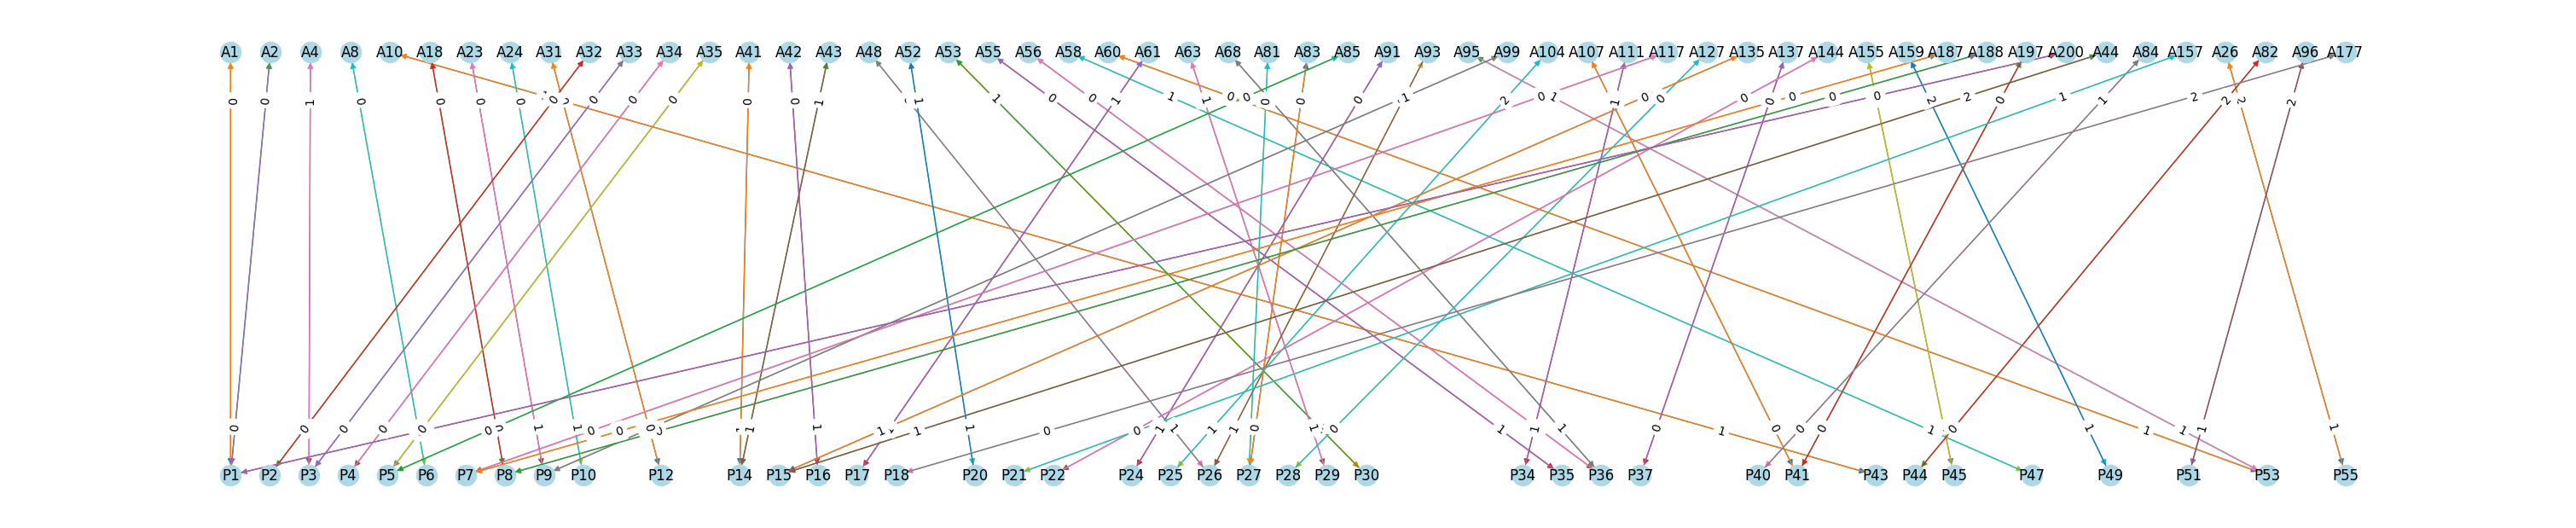

In [13]:
# plotting graph
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

G = nx.DiGraph()

node_labels = {}
total_weight =0
for student, project in edges:
    G.add_node(student, bipartite=1)
    node_labels.update({student : student.student_id})
    
    G.add_node(project, bipartite=0)
    node_labels.update({project : project.project_id})
    
    weight_project = rank_project(student, project)
    G.add_edge(student, project, weight1=weight_project)
    
    weight_student = rank_student(student)
    G.add_edge(project, student, weight2=weight_student)
    total_weight += weight_student + weight_project

print(f"Total weight of edges: {total_weight}")

# Generate edge colors using a colormap
edge_colors = [cm.tab10 (i % 10) for i, _ in enumerate(G.edges())]

fig_horizontal = plt.figure()
fig_horizontal.set_figwidth(30)
fig_horizontal.set_figheight(6)

pos = nx.bipartite_layout(G, projects, align="horizontal")
fig_horizontal = nx.draw(G, pos=pos, with_labels=True, labels=node_labels, node_color="lightblue", edge_color=edge_colors)

# Draw edge labels for both directions
edge_labels1 = nx.get_edge_attributes(G, 'weight1')
edge_labels2 = nx.get_edge_attributes(G, 'weight2')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels1, label_pos=0.1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels2, label_pos=0.1)

plt.show(fig_horizontal)
plt.close()